[View in Colaboratory](https://colab.research.google.com/github/ZackAkil/rotting-zombie-model/blob/master/Data_rot_fake_traffic_generation.ipynb)

# Data Rot Simulation
Genrate 2 data sets and simulate a model progressily degenerating in proformance as the 2nd dataset takes over 

In [0]:
from sklearn.datasets import make_classification

In [0]:
import matplotlib.pyplot as plt

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
import numpy as np

## Create first data set 

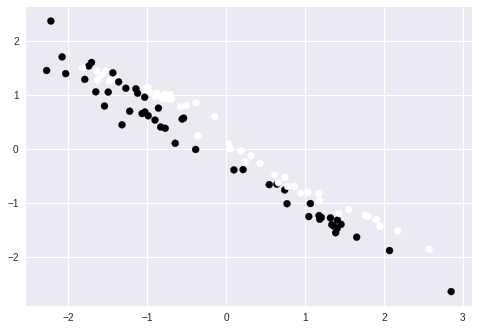

(100, 4)

In [0]:
x_1, y_1 = make_classification(random_state=99, n_features=4, n_redundant=1)
plt.scatter(x_1[:,0], x_1[:,1], c=y_1)
plt.show()
x_1.shape

## Create second data set 

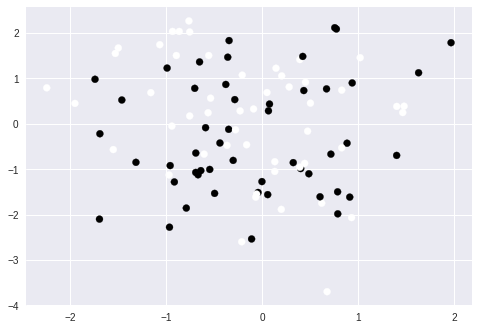

(100, 4)

In [0]:
x_2, y_2 = make_classification(random_state=16, n_features=4, n_redundant=1)
plt.scatter(x_2[:,0], x_2[:,1], c=y_1)
plt.show()
x_2.shape

# Test predictability of data sets

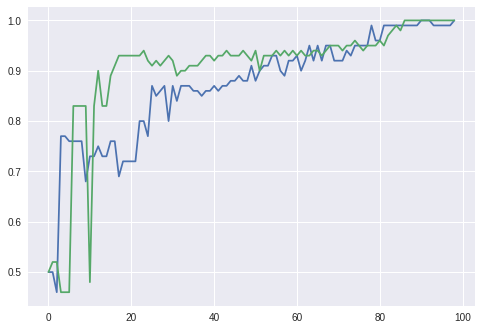

In [0]:
def grow_dataset_plot(x, y):

  clf = DecisionTreeClassifier()

  scores = []

  for i in range(1, 100):

    clf.fit(x[:i],y[:i])

    scores.append(clf.score(x,y))
  plt.plot(scores)
  
grow_dataset_plot(x_1, y_1)
grow_dataset_plot(x_2, y_2)

## Merge dataset function

In [0]:
import numpy as np

# Simulate data rot over time (as new ground triths are reported)

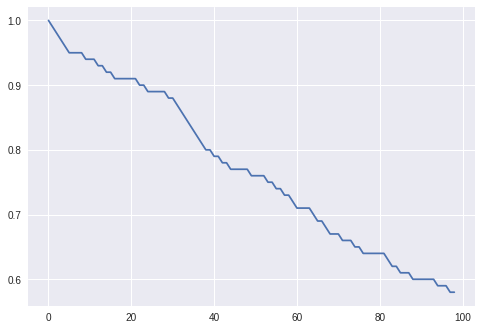

In [0]:
clf = DecisionTreeClassifier()

clf.fit(x_1, y_1)

scores = []

for i in range(1, 100):
  
  x = np.concatenate((x_1[i:], x_2[:i]))
  y = np.concatenate((y_1[i:], y_2[:i]))

  scores.append(clf.score(x, y))
plt.plot(scores)

# Simulate re-training overtime with ground truths

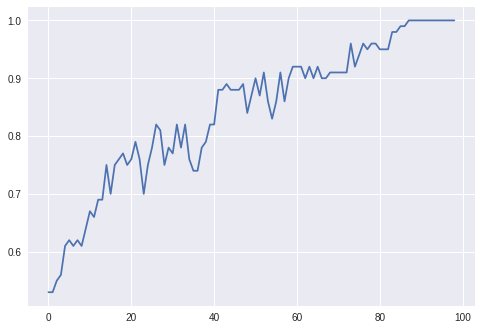

In [0]:
clf = DecisionTreeClassifier()

scores = []

all_x = np.concatenate((x_1, x_2))
all_y = np.concatenate((y_1, y_2))

for i in range(1, 100):
  
  x = all_x[i:100+i]
  y = all_y[i:100+i]

  clf.fit(x, y)

  scores.append(clf.score(x_2, y_2))
plt.plot(scores)

# Train intial model

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    x_1, y_1, test_size=0.33, random_state=42)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.7878787878787878

In [0]:
clf.score(x_1, y_1)

0.93

# Save model

In [0]:
from sklearn.externals import joblib

In [0]:
joblib.dump(clf, 'model.joblib')

['model.joblib']

## Upload to GCP

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
!gsutil cp model.joblib gs://rotting-sklearn-models/v1/model.joblib

Copying file://model.joblib [Content-Type=application/octet-stream]...
/ [1 files][  2.6 KiB/  2.6 KiB]                                                
Operation completed over 1 objects/2.6 KiB.                                      


# Call from cloud functions

In [0]:
import requests

In [0]:
def gen_rand_row(x, y):
  random_index = np.random.randint(0, len(x))
  random_x = x[random_index].tolist()
  random_y = y[random_index]
  return random_x, random_y

random_x, random_y = gen_rand_row(x_1, y_1)

In [0]:
model_url = "predict-ml-engine-url"

req = requests.post(model_url, json={'model':'zombies', 'instances':[random_x]})
preds = req.json()['predictions'][0]
preds

0

In [0]:
feedback_url = "ml-engine-feedback-url"
req = requests.post(feedback_url, json={"model":"v1", 
                                        "input data":random_x, 
                                        "prediction": 5, 
                                        "was correct": True})
req.json()

{'input data': [-0.6905273874655921,
  0.9203063836449301,
  -1.7141987499815876,
  1.3607762483499524],
 'model': 'v1',
 'prediction': 5,
 'time': '2018-10-22 14:04:17.390947',
 'was correct': True}

# Generate fake predictions and feedback

In [0]:
def submit_feedback(x, y, model='v1'):

  for i in range(50):

    random_x, random_y = gen_rand_row(x, y)

    # get prediction from ml-engine   
    req = requests.post(model_url, json={'model':'zombies/versions/'+model, 'instances':[random_x]})
    preds = req.json()['predictions'][0]

    # submit feedback
    req = requests.post(feedback_url, json={"model":model, 
                                          "input data":random_x, 
                                          "prediction": preds, 
                                          "was correct": bool(preds == random_y)})
    print(i)
  

In [0]:
submit_feedback(x_2, y_2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


# Fetch feedback data from Data Store

In [0]:
!pip install -qq google-cloud-datastore

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
client = datastore.Client('project id')

In [0]:
query = client.query(kind='prediction-feedback')
query.order = ['time']
data = list(query.fetch())
len(data)

416

In [0]:
len([d for d in data if d['was correct']]) / len(data)

0.875

Text(0.5,1,'Model accuracy since deployed')

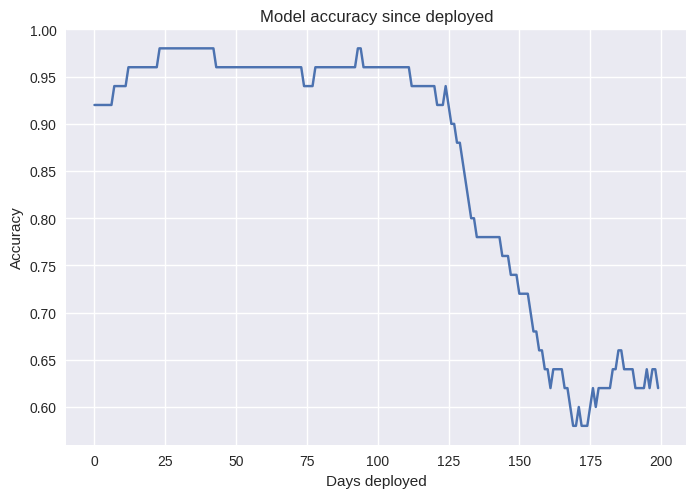

In [0]:
def plot_performance(data):
  window = 50

  perf = []

  for i in range(len(data) - window):

    data_slice = data[i:i+window]

    accuracy = len([d for d in data_slice if d['was correct']]) / len(data_slice)

    perf.append(accuracy)

  plt.plot(perf)
  
plt.figure(dpi=100)
plot_performance(data[:250])
plt.xlabel('Days deployed')
plt.ylabel('Accuracy')
plt.title('Model accuracy since deployed')




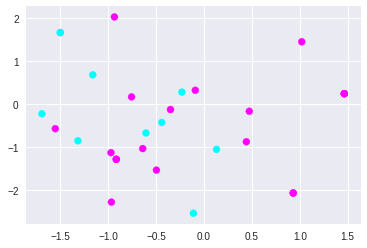

In [0]:
#@title INspect input data { run: "auto" }
start = 187 #@param {type:"slider", min:0, max:200, step:1}
window_size = 65 #@param {type:"slider", min:1, max:100, step:1}


points = [d['input data'] for d in data[start : start+window_size]]
correct = [int(d['was correct']) for d in data[start : start+window_size]]

np_points = np.array(points)

plt.scatter(np_points[:,0], np_points[:,1], c=correct, cmap='cool')
plt.show()



# What to do!

Becuas eit seems like the previous population is no longer present in the data, then it can be assumed that the zombie population has evolved and therefore we should disregard the old data and train a completly new model on new data. 

If however the old population was still present then we could look at combining the data and retraining. We then would need to think about either keeping it a binary classification task or making a new classification label for the new type of zombie (making it a multi-classification problem with 3 classes).

In [0]:
new_data = data[-100:]

In [0]:
new_x = [d['input data'] for d in new_data]
new_y = [d['prediction'] if d['was correct'] else abs(d['prediction'] - 1) for d in new_data ]


In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    new_x, new_y, test_size=0.33, random_state=42)

new_clf = DecisionTreeClassifier()
new_clf.fit(X_train, y_train)

new_clf.score(X_test, y_test)

0.9696969696969697

In [0]:
joblib.dump(new_clf, 'model.joblib')

['model.joblib']

In [0]:
!gsutil cp model.joblib gs://my-first-sklearn/rot/v2/model.joblib

Copying file://model.joblib [Content-Type=application/octet-stream]...
/ [1 files][  1.6 KiB/  1.6 KiB]                                                
Operation completed over 1 objects/1.6 KiB.                                      


# send new data to new model

In [0]:
submit_feedback(x_2, y_2, model='v2')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [0]:
query = client.query(kind='prediction-feedback')
query.order = ['time']
data = list(query.fetch())
len(data)

416

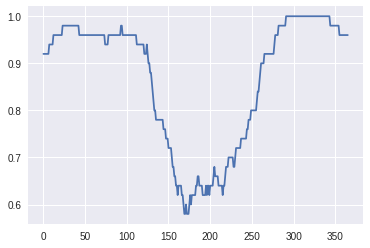

In [0]:
plot_performance(data)

# We fought off model rot!